# Predicting Stroke using Machine Learning
Fall 2024 Data Science Project

August Joergensen (xx), Noah Ryu Nguyen (121329011)

## Contributions:

For each member, list which of the following sections they worked on, and

summarize the contributions in 1-2 sentences. Be specific!

A: Project idea

B: Dataset Curation and Preprocessing

C: Data Exploration and Summary Statistics

D: ML Algorithm Design/Development

E: ML Algorithm Training and Test Data Analysis

F: Visualization, Result Analysis, Conclusion

G: Final Tutorial Report Creation

H: Additional (not listed above)

## Introduction *The introduction should motivate your work: what is your topic? What question(s) are you trying to answer with your analysis? Why is answering those questions important?*

## Data curation. *Cite the source(s) of your data. Explain what it is. Transform the data so that it is ready for analysis. For example, set up a database and use SQL to query for data, or organize a pandas DataFrame.*

In this notebook we will go through the preprocessing of the data and the basic data exploration. Our data set is called "healthcare-dataset-stroke-data.csv" and it contains information about patients and whether they had a stroke or not, and many of the patients' characteristics.

In [1]:
# Core libraries
import numpy as np
import pandas as pd

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Scikit-learn modules
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    train_test_split, KFold, GridSearchCV, StratifiedKFold, cross_val_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, accuracy_score, recall_score, confusion_matrix,
    roc_auc_score, roc_curve
)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Statistical tests and utilities
from scipy.stats import levene, chisquare
from statsmodels.stats.contingency_tables import mcnemar
from imblearn.over_sampling import SMOTE
from collections import Counter

In [2]:
# seeding for reproducibility
np.random.seed(42)

In [3]:
# Import dataset and overview
dataset = pd.read_csv('healthcare-dataset-stroke-data.csv')
dataset.head(20)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
6,53882,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
7,10434,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
9,60491,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


From this we can make several intersting observations. First we see that we have multiple features that are strings (objects), second we see that we have missing values in the bmi column. We will have to deal with these issues before we can start building our models.

## Exploratory data analysis (Checkpoint 2.)

### Gender column from string to binary values

We begin by converting the gender strings to binary values. We will assign 1 to Male and 0 to Female.

In [5]:
# Here we make the gender column binary
dataset['gender'] = dataset['gender'].map({'Male': 1, 'Female': 0})
dataset.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1.0,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,0.0,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,1.0,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,0.0,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,0.0,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [6]:
dataset['gender'].unique()

array([ 1.,  0., nan])

We see that there is a nan value in the gender column. Lets see how many nan values we have in the and how they look.

In [7]:
nan_gender_rows = dataset[dataset['gender'].isna()]
print(nan_gender_rows)

         id  gender   age  hypertension  heart_disease ever_married work_type  \
3116  56156     NaN  26.0             0              0           No   Private   

     Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
3116          Rural             143.33  22.4  formerly smoked       0  


Since it's a single occassion we will just drop the row with the nan value.

In [8]:
dataset.dropna(subset=['gender'], inplace=True)

### Converting 'ever_married' column to binary values

We see that the 'ever_married' column is also a string. We will convert it to binary values. We will assign 1 to Yes and 0 to No.

In [9]:
dataset['ever_married'] = dataset['ever_married'].map({'Yes': 1, 'No': 0})

In [10]:
dataset['ever_married'].unique()

array([1, 0])

### Converting 'work_type' column to intergers

In [11]:
dataset['work_type'].unique()

array(['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'],
      dtype=object)

We will assign a number to each work type. We will assign 0 to 'Private', 1 to 'Self-employed', 2 to 'Govt_job', 3 to 'children' and 4 to 'Never_worked'.

In [12]:
dataset['work_type'] = dataset['work_type'].map({'Private': 0, 'Self-employed': 1, 'Govt_job': 2, 'children': 3, 'Never_worked': 4})

### Converting 'Residence_type' column to binary values

In [13]:
dataset['Residence_type'].unique()

array(['Urban', 'Rural'], dtype=object)

We will assign 1 to Urban and 0 to Rural.

In [14]:
dataset['Residence_type'] = dataset['Residence_type'].map({'Urban': 1, 'Rural': 0})

### Converting 'smoking_status' column to intergers

In [15]:
dataset['smoking_status'].unique()

array(['formerly smoked', 'never smoked', 'smokes', 'Unknown'],
      dtype=object)

In [16]:
# Here we will check the amount of missing values in the dataset

print(dataset['smoking_status'].value_counts())

# percentage
print(dataset['smoking_status'].value_counts(normalize=True))

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     884
smokes              789
Name: count, dtype: int64
smoking_status
never smoked       0.370327
Unknown            0.302212
formerly smoked    0.173028
smokes             0.154433
Name: proportion, dtype: float64


We will assign a number to each smoking status. We will assign 0 to 'never smoked', 1 to 'formerly smoked', 2 to 'smokes' and 3 to 'Unknown'.


In [17]:
dataset['smoking_status'] = dataset['smoking_status'].map({'never smoked': 0, 'formerly smoked': 1, 'smokes': 2, 'Unknown': 3})

dataset.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1.0,67.0,0,1,1,0,1,228.69,36.6,1,1
1,51676,0.0,61.0,0,0,1,1,0,202.21,NaN,0,1
2,31112,1.0,80.0,0,1,1,0,0,105.92,32.5,0,1
3,60182,0.0,49.0,0,0,1,0,1,171.23,34.4,2,1
4,1665,0.0,79.0,1,0,1,1,0,174.12,24.0,0,1


In [18]:
dataset.dtypes

id                     int64
gender               float64
age                  float64
hypertension           int64
heart_disease          int64
ever_married           int64
work_type              int64
Residence_type         int64
avg_glucose_level    float64
bmi                  float64
smoking_status         int64
stroke                 int64
dtype: object

We have now converted all the string columns to numerical values. Now we check for final NAN values.

In [19]:
dataset.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Lots of missing values in the bmi column. Let's check what percentage of the data is missing.

In [20]:
# Here we check the percentage of missing values in the BMI column
total_rows = len(dataset)
missing_bmi_rows = dataset['bmi'].isna().sum()
missing_bmi_percentage = (missing_bmi_rows / total_rows) * 100
print(f"Percentage of missing BMI data: {missing_bmi_percentage:.2f}%")

Percentage of missing BMI data: 3.93%


Since this is a significant amount of data we will have to deal with this. We will fill the missing values with the mean of the bmi column. But we will add a little normally distributed random noise to the data to make it more realistic using standard deviations. This will make the missing values distribute more evenly. 

In [21]:
bmi_mean = dataset['bmi'].mean()
bmi_std = dataset['bmi'].std()

# The noise will have a mean of 0 and a standard deviation equal to the BMI std
noise = np.random.normal(0, bmi_std, size=dataset['bmi'].isna().sum())

# Creating mask for missing values
mask = dataset['bmi'].isna()

# Imputing missing values
dataset.loc[mask, 'bmi'] = bmi_mean + noise


print(f"Missing BMI data after imputation: {dataset['bmi'].isna().sum()}")

Missing BMI data after imputation: 0


Text(0.5, 1.0, 'Distribution of BMI')

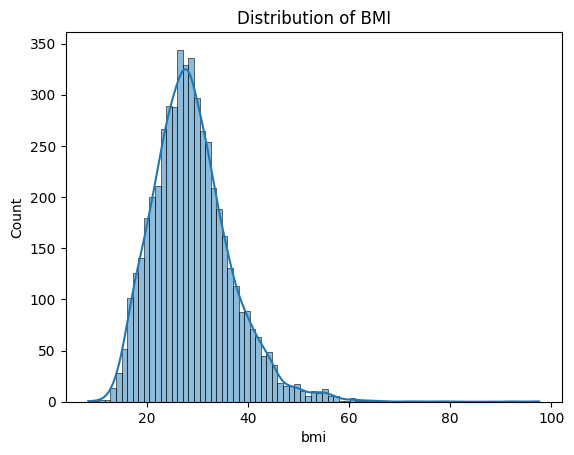

In [22]:
# Plotting the distribution of the BMI
sns.histplot(dataset['bmi'], kde=True)
plt.title('Distribution of BMI')

Now we see that the bmi distribution still fits a normal distribution, even though we added all the missing values around the mean. 

# Outliers

We have three features that are non-binary: BMI, age, avg_gluclose_level. We will check for potential outliers in these columns

In [23]:

fig = make_subplots(rows=1, cols=3, subplot_titles=('BMI', 'Age', 'Avg Glucose Level'))

# Adding a boxplot for BMI 
fig.add_trace(
    go.Box(y=dataset['bmi'], name='BMI', marker_color='skyblue', 
           boxpoints='outliers', 
           marker=dict(outliercolor='red', color='skyblue')), 
    row=1, col=1
)

# Adding a boxplot for Age 
fig.add_trace(
    go.Box(y=dataset['age'], name='Age', marker_color='lightgreen', 
           boxpoints='outliers', 
           marker=dict(outliercolor='orange', color='lightgreen')), 
    row=1, col=2
)

# Adding a boxplot for Avg Glucose Level 
fig.add_trace(
    go.Box(y=dataset['avg_glucose_level'], name='Avg Glucose Level', marker_color='salmon', 
           boxpoints='outliers', 
           marker=dict(outliercolor='purple', color='salmon')), 
    row=1, col=3
)

# Update layout to adjust subplot titles and spacing
fig.update_layout(title_text='Boxplots for BMI, Age, and Avg Glucose Level',
                  showlegend=False,
                  height=500, width=1000)

# Show plot
fig.show()

The Age feature seems good, however BMI and Avg Glucose Level have lots of extreme values so we will have to decide whether or not they are outliers or actual cases of extreme values.

First we will check the BMI and put the outliers up with the age values since a baby cannot have a bmi of let's say 100.

In [24]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = dataset['bmi'].quantile(0.25)
Q3 = dataset['bmi'].quantile(0.75)

# Calculate IQR (Interquartile Range)
IQR = Q3 - Q1

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Detect outliers in BMI
outliers_bmi = dataset[(dataset['bmi'] < lower_bound) | (dataset['bmi'] > upper_bound)]

# Print out the potential BMI outliers
print("Potential BMI Outliers:")
print(outliers_bmi[['age', 'bmi']])

# Scatter plot to visualize outliers with age
fig = px.scatter(outliers_bmi, x='age', y='bmi', 
                 title='Extreme BMI Values vs Age',
                 labels={'bmi': 'BMI', 'age': 'Age'},
                 color='age')

fig.show()

Potential BMI Outliers:
       age   bmi
21    52.0  48.9
113   45.0  56.6
254   47.0  50.1
258   74.0  54.6
270   57.0  60.9
...    ...   ...
4858  43.0  47.6
4906  53.0  54.1
4952  51.0  56.6
5009  50.0  49.5
5057  49.0  47.6

[113 rows x 2 columns]


We first identified extreme BMI values by detecting outliers using the IQR method. The outliers are those BMI values that fall outside of the range defined by the interquartile range (IQR), which captures the middle 50% of the data. By plotting these outliers against the age values, we can assess whether certain BMI values are unusually high or low relative to age. This is important because, for example, a very young child should not have an excessively high BMI. In this scatter plot, the color represents the age, helping us visualize how BMI outliers vary across different age groups.

In [25]:
Q1 = dataset['bmi'].quantile(0.25)
Q3 = dataset['bmi'].quantile(0.75)
IQR = Q3 - Q1

lower_bound_iqr = Q1 - 1.5 * IQR
upper_bound_iqr = Q3 + 1.5 * IQR

# Detect outliers based on IQR
outliers_bmi_iqr = dataset[(dataset['bmi'] < lower_bound_iqr) | (dataset['bmi'] > upper_bound_iqr)]

# Now, remove the points that are beyond 2 STDV from the mean of the outliers
mean_bmi_outliers = outliers_bmi_iqr['bmi'].mean()
std_bmi_outliers = outliers_bmi_iqr['bmi'].std()

# 2 STDV bounds for the detected IQR-based outliers
lower_bound_2stdv = mean_bmi_outliers - 2 * std_bmi_outliers
upper_bound_2stdv = mean_bmi_outliers + 2 * std_bmi_outliers

# Filter the IQR-based outliers to remove those beyond 2 STDV
filtered_outliers = outliers_bmi_iqr[(outliers_bmi_iqr['bmi'] >= lower_bound_2stdv) & 
                                     (outliers_bmi_iqr['bmi'] <= upper_bound_2stdv)]

print("Filtered BMI Outliers after removing 2 STDV:")
print(filtered_outliers[['age', 'bmi']])

fig = px.scatter(filtered_outliers, x='age', y='bmi', 
                 title='Filtered Extreme BMI Values (after removing 2 STDV) vs Age',
                 labels={'bmi': 'BMI', 'age': 'Age'},
                 color='age')

fig.show()

Filtered BMI Outliers after removing 2 STDV:
       age   bmi
21    52.0  48.9
113   45.0  56.6
254   47.0  50.1
258   74.0  54.6
270   57.0  60.9
...    ...   ...
4858  43.0  47.6
4906  53.0  54.1
4952  51.0  56.6
5009  50.0  49.5
5057  49.0  47.6

[108 rows x 2 columns]


After detecting the extreme BMI values using the IQR method, we further refined the outliers by removing points that were more than 2 standard deviations away from the mean of these outliers. This step helps in eliminating the most extreme cases, where the BMI values might be considered statistical anomalies. The filtered outliers are plotted against the age values, similar to the previous plot, but now we see only those points that are within a more reasonable range. By comparing the filtered extreme BMI values to the age values, we can gain further insights into whether these BMI values are still unusual given the individual's age.

In [26]:
dataset = dataset[(dataset['bmi'] >= lower_bound_iqr) & (dataset['bmi'] <= upper_bound_iqr) | 
                  ((dataset['bmi'] >= lower_bound_2stdv) & (dataset['bmi'] <= upper_bound_2stdv))]

print(f"Updated dataset size after removing outliers: {len(dataset)}")
dataset.head()

Updated dataset size after removing outliers: 5104


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1.0,67.0,0,1,1,0,1,228.69,36.600000,1,1
1,51676,0.0,61.0,0,0,1,1,0,202.21,32.795912,0,1
2,31112,1.0,80.0,0,1,1,0,0,105.92,32.500000,0,1
3,60182,0.0,49.0,0,0,1,0,1,171.23,34.400000,2,1
4,1665,0.0,79.0,1,0,1,1,0,174.12,24.000000,0,1


Now let's look at the glucose levels and do the same

In [27]:

Q1 = dataset['avg_glucose_level'].quantile(0.25)
Q3 = dataset['avg_glucose_level'].quantile(0.75)

IQR = Q3 - Q1

# define lower and upper bounds for outliers based on avg_glucose_level
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# detect outliers in avg_glucose_level
outliers_glucose = dataset[(dataset['avg_glucose_level'] < lower_bound) | (dataset['avg_glucose_level'] > upper_bound)]

print("Potential Avg Glucose Level Outliers:")
print(outliers_glucose[['age', 'avg_glucose_level']])

# scatter plot to visualize avg_glucose_level outliers with age
fig = px.scatter(outliers_glucose, x='age', y='avg_glucose_level', 
                 title='Extreme Avg Glucose Level Values vs Age',
                 labels={'avg_glucose_level': 'Avg Glucose Level', 'age': 'Age'},
                 color='age')

fig.show()


Potential Avg Glucose Level Outliers:
       age  avg_glucose_level
0     67.0             228.69
1     61.0             202.21
3     49.0             171.23
4     79.0             174.12
5     81.0             186.21
...    ...                ...
5061  41.0             223.78
5062  82.0             211.58
5063  39.0             179.38
5064  70.0             193.88
5076  34.0             174.37

[625 rows x 2 columns]


In [28]:
# Here, we will remove the outliers based on the IQR method and then filter out the points that are beyond 2 STDV from the mean of the outliers

Q1 = dataset['avg_glucose_level'].quantile(0.25)
Q3 = dataset['avg_glucose_level'].quantile(0.75)
IQR = Q3 - Q1

lower_bound_iqr = Q1 - 1.5 * IQR
upper_bound_iqr = Q3 + 1.5 * IQR

outliers_glucose_iqr = dataset[(dataset['avg_glucose_level'] < lower_bound_iqr) | (dataset['avg_glucose_level'] > upper_bound_iqr)]

mean_glucose_outliers = outliers_glucose_iqr['avg_glucose_level'].mean()
std_glucose_outliers = outliers_glucose_iqr['avg_glucose_level'].std()

lower_bound_2stdv = mean_glucose_outliers - 2 * std_glucose_outliers
upper_bound_2stdv = mean_glucose_outliers + 2 * std_glucose_outliers

filtered_outliers = outliers_glucose_iqr[(outliers_glucose_iqr['avg_glucose_level'] >= lower_bound_2stdv) & 
                                         (outliers_glucose_iqr['avg_glucose_level'] <= upper_bound_2stdv)]

dataset = dataset[~dataset.index.isin(outliers_glucose_iqr[~outliers_glucose_iqr.index.isin(filtered_outliers.index)].index)]

print(f"Number of outliers remaining after removing 2 STDV: {len(filtered_outliers)}")
outliers_removed = len(outliers_glucose_iqr) - len(filtered_outliers)
print(f"Number of outliers removed based on 2 STDV: {outliers_removed}")

fig = px.scatter(filtered_outliers, x='age', y='avg_glucose_level', 
                 title='Filtered Extreme Avg Glucose Level Values (after removing 2 STDV) vs Age',
                 labels={'avg_glucose_level': 'Avg Glucose Level', 'age': 'Age'},
                 color='age')

fig.show()

Number of outliers remaining after removing 2 STDV: 604
Number of outliers removed based on 2 STDV: 21


After identifying extreme outliers in average glucose levels using the IQR method, we applied a further filter based on 2 standard deviations from the mean of the IQR-detected outliers. This process allowed us to exclude the most extreme values while retaining those that were reasonably close to the average. The final dataset was updated to reflect the removal of these outliers, ensuring more accurate and reliable analysis moving forward.

In [29]:
fig = make_subplots(rows=1, cols=3, subplot_titles=('BMI', 'Age', 'Avg Glucose Level'))

# Adding a boxplot for BMI 
fig.add_trace(
    go.Box(y=dataset['bmi'], name='BMI', marker_color='skyblue', 
           boxpoints='outliers', 
           marker=dict(outliercolor='red', color='skyblue')), 
    row=1, col=1
)

# Adding a boxplot for Age 
fig.add_trace(
    go.Box(y=dataset['age'], name='Age', marker_color='lightgreen', 
           boxpoints='outliers', 
           marker=dict(outliercolor='orange', color='lightgreen')), 
    row=1, col=2
)

# Adding a boxplot for Avg Glucose Level 
fig.add_trace(
    go.Box(y=dataset['avg_glucose_level'], name='Avg Glucose Level', marker_color='salmon', 
           boxpoints='outliers', 
           marker=dict(outliercolor='purple', color='salmon')), 
    row=1, col=3
)

# Update layout to adjust subplot titles and spacing
fig.update_layout(title_text='Boxplots for BMI, Age, and Avg Glucose Level',
                  showlegend=False,
                  height=500, width=1000)

# Show plot
fig.show()

### Variances of features

Let's have a look at the variances of the features, age, avg_glucose_level and bmi

In [30]:
print(dataset[['age', 'avg_glucose_level', 'bmi']].var())

age                   510.969734
avg_glucose_level    1969.372147
bmi                    58.833108
dtype: float64


Unfortunately we see a big difference in variances, but lets confirm this first with a hypothesis test. Here we should choose a Levene test since we are comparing the variances of multiple groups.


We are conducting a hypothesis test to determine whether the variances of the three features (`age`, `avg_glucose_level`, and `bmi`) are significantly different.

#### **Null Hypothesis (H₀):**
The variances of the features are equal.
$H_0: \sigma_{\text{age}}^2 = \sigma_{\text{avg\_glucose\_level}}^2 = \sigma_{\text{bmi}}^2$


#### **Alternative Hypothesis (H₁):**
At least one feature has a variance that is different from the others.
$H_1: \text{At least one variance is different}$

#### **Test:**
We will use **Levene's Test** to test for equality of variances.

- If the **p-value < 0.05**, we will reject the null hypothesis, indicating that the variances are significantly different.
- If the **p-value ≥ 0.05**, we fail to reject the null hypothesis, suggesting there is no significant difference in variances.


In [31]:
stat, p_value = levene(dataset['age'], dataset['avg_glucose_level'], dataset['bmi'], center='mean')
print(f"Levene's test statistic: {stat}")
print(f"p-value: {p_value}")

Levene's test statistic: 2441.9532774953777
p-value: 0.0


We see that the p-value is less than 0.05, so we reject the null hypothesis. This means that the variances are significantly different. We will have to standardize the data before we can build our models.

This is how the data looks without having standardized it. We see that the features are on different scales.

In [32]:
# Select specific numerical columns
selected_cols = ['age', 'avg_glucose_level', 'bmi']

# Melt the dataset for easier plotting 
df_melted = dataset.reset_index()[['index'] + selected_cols].melt(id_vars=['index'], 
                                                                  value_vars=selected_cols, 
                                                                  var_name='Feature', 
                                                                  value_name='Value')

# Plot 
fig = px.line(df_melted, x='index', y='Value', color='Feature',
              title='Line Plot of Selected Numerical Features',
              labels={'index': 'Observations', 'Value': 'Values'})

# Show the plot
fig.show()

Now we can try and standardize the data. We will use the StandardScaler from sklearn to do this. This will make the features have a mean of 0 and a standard deviation of 1.

In [33]:
# Split the dataset into features and target
selected_cols = ['age', 'avg_glucose_level', 'bmi']

# Standardize the selected columns
scaler = StandardScaler()

# Fit and transform the data
scaled_data = scaler.fit_transform(dataset[selected_cols])

# Replace the original columns with the scaled data
dataset[selected_cols] = scaled_data

# Melt the dataset for easier plotting
df_melted = dataset.reset_index()[['index'] + selected_cols].melt(id_vars=['index'], 
                                                                  value_vars=selected_cols, 
                                                                  var_name='Feature', 
                                                                  value_name='Scaled Value')

# Plot using Plotly Express
fig = px.line(df_melted, x='index', y='Scaled Value', color='Feature',
              title='Line Plot of Scaled Selected Numerical Features',
              labels={'index': 'Observations', 'Scaled Value': 'Scaled Values'})

# Show the plot
fig.show()

The result of the standardization looks like this and we see that the features are now on the same scale. 

# Smoker Unknown

Let's first take a look at the distribution of the smoking status. We see that there are a lot of unknown values. 

In [34]:
# Mapping dictionary
smoking_status_map = {'never smoked': 0, 'formerly smoked': 1, 'smokes': 2, 'Unknown': 3}

# Reverse the mapping dictionary
reverse_smoking_status_map = {v: k for k, v in smoking_status_map.items()}

# Print most frequent smoking status with original names and their percentages
value_counts = dataset['smoking_status'].value_counts()
total_count = len(dataset['smoking_status'])

for status, count in value_counts.items():
    percentage = (count / total_count) * 100
    print(f"{status} ({reverse_smoking_status_map[status]}): {count} ({percentage:.2f}%)")

0 (never smoked): 1885 (37.08%)
3 (Unknown): 1538 (30.26%)
1 (formerly smoked): 877 (17.25%)
2 (smokes): 783 (15.40%)


The presence of "Unknown" in the smoking status variable poses a challenge for accurate data analysis. These "Unknown" values act similarly to missing data (like NaN) and can distort the relationships between variables. In the original dataset, the "Unknown" category creates uncertainty, as it doesn't provide any useful information about the smoking habits of these individuals. This makes it difficult to assess the true correlations involving smoking status.

Imputation offers one solution by predicting these missing values based on patterns in the data. However, this can introduce bias if the predicted values aren't fully accurate. Another approach is to remove the "Unknown" values entirely, but this reduces the dataset's size and may impact the overall quality of analysis.

Addressing this issue is crucial for building reliable models and ensuring the correlations between variables remain meaningful.

We are gonna try every approach and see which one gives us the best results.

Below we will try to predict the missing values using a Random Forest Classifier. We will use the other features to predict the missing values in the smoking_status column. Although we are going to drop the 'id' and 'smoking_status' columns since we are going to predict the missing values in the 'smoking_status' column, and 'id' is not a feature that can help us predict the missing values.

In [35]:
# Here we are training a Random Forest Classifier to predict the 'Unknown' smoking statuses

# Filter out the 'Unknown' smoking statuses (where smoking_status == 3)
filtered_data = dataset[dataset['smoking_status'] != 3]

# Drop the 'id' column and the 'smoking_status' column (target variable)
X = filtered_data.drop(['id', 'smoking_status'], axis=1)
y = filtered_data['smoking_status']

# Initialize KFold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize lists to store evaluation metrics for each fold
accuracy_scores = []
classification_reports = []

# Perform KFold cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Training fold {fold + 1}...")

    # Split the data into training and testing sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the RandomForestClassifier
    rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=42, class_weight='balanced')
    rf_classifier.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = rf_classifier.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    print(f"Accuracy for fold {fold + 1}: {accuracy:.2f}")

    # Store the classification report for this fold
    report = classification_report(y_test, y_pred, target_names=['never smoked', 'formerly smoked', 'smokes'], output_dict=True)
    classification_reports.append(report)

# Calculate and display the average accuracy across all folds
avg_accuracy = np.mean(accuracy_scores)
print(f"\nAverage accuracy across all folds: {avg_accuracy:.2f}")


# Now that the model is validated, we will retrain on the entire dataset to predict the 'Unknown' smoking statuses

# Train on the entire filtered dataset
rf_classifier.fit(X, y)

# Predict smoking status for the 'Unknown' cases
unknown_data = dataset[dataset['smoking_status'] == 3]
X_unknown = unknown_data.drop(['id', 'smoking_status'], axis=1)
predicted_smoking_status = rf_classifier.predict(X_unknown)

# Create a new dataset with these predictions
dataset_rf_imputed = dataset.copy()
dataset_rf_imputed.loc[dataset_rf_imputed['smoking_status'] == 3, 'smoking_status'] = predicted_smoking_status

print("Smoking statuses imputed for unknown cases.")

Training fold 1...
Accuracy for fold 1: 0.50
Training fold 2...
Accuracy for fold 2: 0.48
Training fold 3...
Accuracy for fold 3: 0.47
Training fold 4...
Accuracy for fold 4: 0.47
Training fold 5...
Accuracy for fold 5: 0.53
Training fold 6...
Accuracy for fold 6: 0.51
Training fold 7...
Accuracy for fold 7: 0.46
Training fold 8...
Accuracy for fold 8: 0.51
Training fold 9...
Accuracy for fold 9: 0.55
Training fold 10...
Accuracy for fold 10: 0.49

Average accuracy across all folds: 0.50
Smoking statuses imputed for unknown cases.


After imputing the "Unknown" smoking statuses using a Random Forest Classifier, we achieved an average cross-validation accuracy of 50%, indicating that the model performs moderately well at predicting the correct smoking status. To assess the quality of the imputation, we compare the distribution of predicted smoking statuses with the baseline assumption that all "Unknown" values belong to the most frequent class, "never smoked" (37.08%).

A statistical test (e.g., a chi-square goodness-of-fit test) can help determine if the distribution of imputed values significantly differs from the baseline assumption. A significant result would suggest that the model captures meaningful patterns in the data rather than simply defaulting to the most frequent class.

In [36]:
# Total number of "Unknown" cases
total_unknown = len(predicted_smoking_status)

# Baseline distribution (assume all "Unknown" are 'never smoked')
baseline_distribution = [37.08, 17.25, 15.40, 30.26]  # percentages
baseline_counts = [total_unknown * (percentage / 100) for percentage in baseline_distribution]  # Convert to absolute counts

# Normalize the baseline counts to ensure the sum matches the total_unknown
baseline_counts_normalized = [count * (total_unknown / sum(baseline_counts)) for count in baseline_counts]

# Distribution of predicted smoking statuses (absolute counts)
imputed_counts = pd.Series(predicted_smoking_status).value_counts()
imputed_counts_full = [imputed_counts.get(i, 0) for i in range(4)]  # Ensure all categories are represented

# Perform chi-square goodness-of-fit test
chi2_stat, p_value = chisquare(f_obs=imputed_counts_full, f_exp=baseline_counts_normalized)

# Print results
print("Chi-Square Test Results:")
print(f"Chi-Square Statistic: {chi2_stat:.4f}")
print(f"P-Value: {p_value:.4f}")

if p_value < 0.05:
    print("The distribution of imputed values significantly differs from the baseline (p < 0.05).")
else:
    print("The distribution of imputed values does not significantly differ from the baseline (p >= 0.05).")

Chi-Square Test Results:
Chi-Square Statistic: 1529.2069
P-Value: 0.0000
The distribution of imputed values significantly differs from the baseline (p < 0.05).


The results of the chi-square test confirm that the model used for imputing "Unknown" smoking statuses has successfully identified meaningful patterns in the data. With a highly significant p-value (p < 0.05) and a chi-square statistic of 1529.21, the distribution of the imputed values significantly differs from the baseline assumption, which assigns all cases to the most frequent class ("never smoked"). This demonstrates that the model is not merely defaulting to the majority class but is instead leveraging patterns in the other features to make more informed predictions.

Now we can create the dataset entirely without the 'Unknown' values in the 'smoking_status' column. 

In [37]:
dataset_removed = dataset[dataset['smoking_status'] != 3]

We compare three versions of our dataset to determine which is best for analysis. The first is the original dataset, which includes all the raw data but has some smoking statuses labeled as "Unknown." While these aren’t technically missing values, "Unknown" acts similarly to missing data (like NaN) in this case. The second is the imputed dataset, where "Unknown" smoking statuses are predicted using a Random Forest model, allowing us to retain more data while preserving relationships between variables. The third version removes all rows with "Unknown" smoking status, reducing the data size but eliminating uncertainty.

By comparing the correlation matrices, we assess how each approach affects the relationships between variables and choose the most reliable dataset for further analysis.

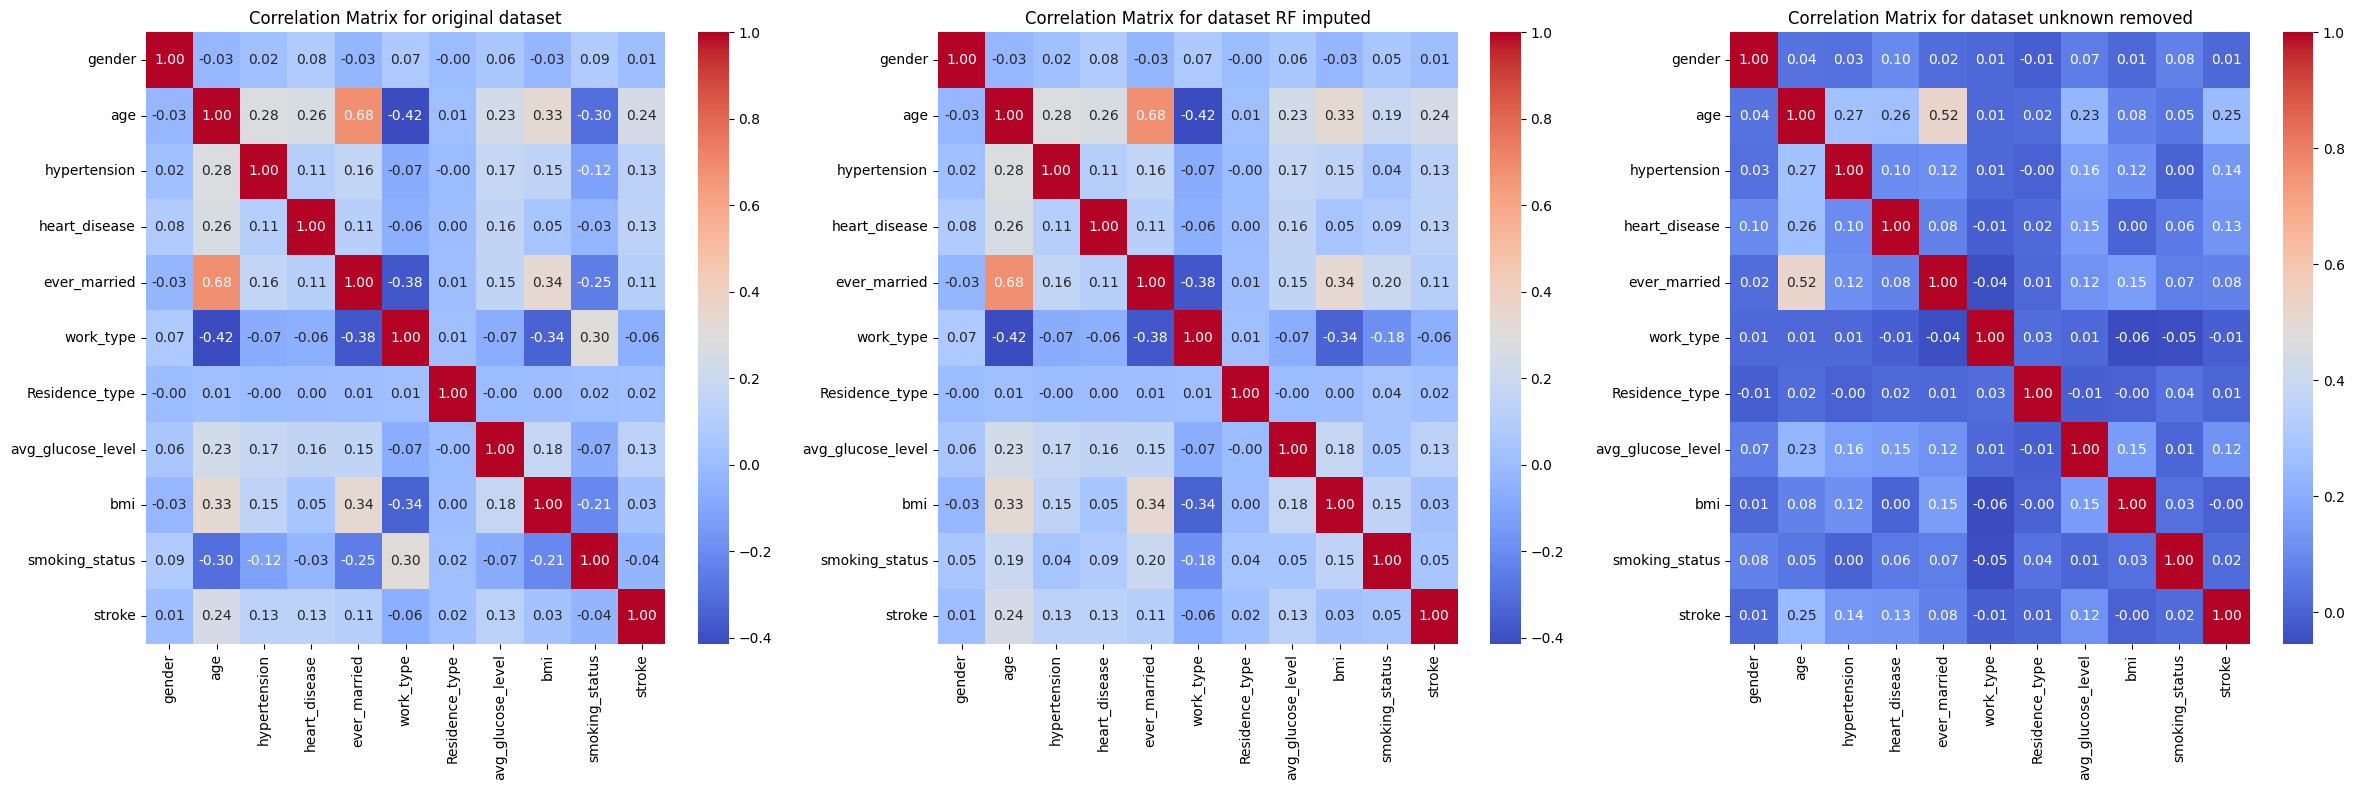

In [38]:
# Drop the 'id' column from each dataset
dataset_no_id = dataset.drop(columns=['id'])
dataset_rf_imputed_no_id = dataset_rf_imputed.drop(columns=['id'])
dataset_removed_no_id = dataset_removed.drop(columns=['id'])

# Compute the correlation matrices
corr_dataset = dataset_no_id.corr()
corr_rf_imputed = dataset_rf_imputed_no_id.corr()
corr_removed = dataset_removed_no_id.corr()

# Plot the correlation matrices side by side
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

sns.heatmap(corr_dataset, annot=True, fmt='.2f', ax=axes[0], cmap='coolwarm')
axes[0].set_title('Correlation Matrix for original dataset')

sns.heatmap(corr_rf_imputed, annot=True, fmt='.2f', ax=axes[1], cmap='coolwarm')
axes[1].set_title('Correlation Matrix for dataset RF imputed')

sns.heatmap(corr_removed, annot=True, fmt='.2f', ax=axes[2], cmap='coolwarm')
axes[2].set_title('Correlation Matrix for dataset unknown removed')

plt.tight_layout()
plt.show()

We decide to move forward with the random forest imputed dataset because it provides a balanced and comprehensive approach to handling missing data while preserving the integrity of the dataset.

First, by using random forest imputation, we address the missing or "unknown" smoking status values in a way that relies on the relationships between other variables in the data. This is much more effective than simply categorizing these values as "Unknown" or removing them entirely. It allows us to retain more data, which increases the sample size and, in turn, the statistical power of our analysis.

Another important reason for choosing this approach is that it preserves the natural structure and relationships within the dataset. Imputation through random forests uses patterns from existing data to predict missing values, which means the dataset remains internally consistent and closer to reality. This increases the accuracy of any insights or models that rely on this data.

Additionally, the imputed dataset retains around 1500 more observations compared to the dataset with outliers removed, ensuring we don’t lose valuable information. The more data we can use, the better our chances of building robust models and drawing meaningful conclusions.

When we compared the correlation matrices, we noticed that the imputed dataset maintained similar relationships to those found in the original dataset, showing that the imputation process didn’t disrupt key correlations. In contrast, removing outliers led to shifts in some relationships, likely due to the reduction in sample size.

In short, choosing the random forest imputed dataset means we keep a more complete dataset, preserve essential correlations, and ensure that missing values are handled thoughtfully. This approach provides a solid foundation for our analysis, leading to more reliable and accurate results.

In [39]:
dataset_rf_imputed.head(20)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1.0,1.054748,0,1,1,0,1,2.775212,1.012276,1,1
1,51676,0.0,0.789290,0,0,1,1,0,2.178456,0.516275,0,1
2,31112,1.0,1.629908,0,1,1,0,0,0.008454,0.477693,0,1
3,60182,0.0,0.258373,0,0,1,0,1,1.480287,0.725426,2,1
4,1665,0.0,1.585665,1,0,1,1,0,1.545417,-0.630591,0,1
5,56669,1.0,1.674151,0,0,1,0,1,1.817878,0.021341,1,1
6,53882,1.0,1.364450,1,1,1,0,0,-0.799014,-0.187277,0,1
7,10434,0.0,1.143234,0,0,0,0,1,-0.251387,-0.787054,0,1
8,27419,0.0,0.700804,0,0,1,0,0,-0.662445,-0.134003,1,1
9,60491,0.0,1.541422,0,0,1,0,1,-1.058630,-0.604513,0,1


This is what the data looks like after we have imputed the missing values in the 'smoking_status' column. 

## Using SMOTE to handle class imbalance in the target variable

Let's try and look at the distribution of the target variable. 

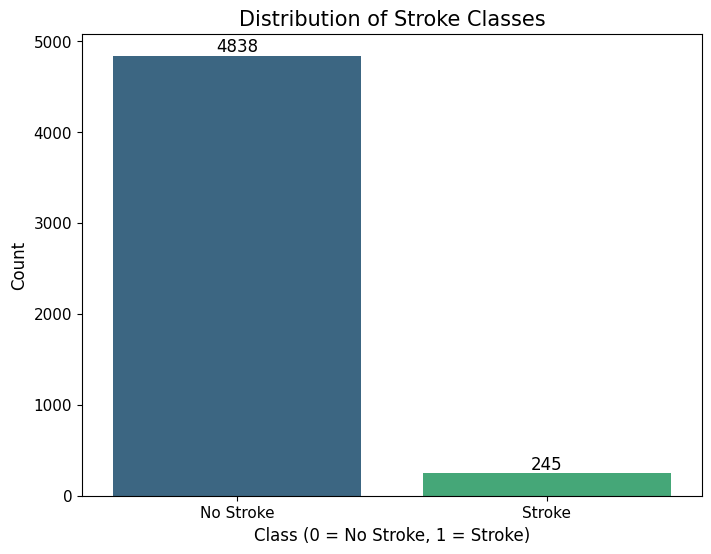

In [40]:
# Make a histogram of the stroke column (y_train)
plt.figure(figsize=(8, 6))
ax = sns.barplot(
    x=dataset_rf_imputed['stroke'].value_counts().index,
    y=dataset_rf_imputed['stroke'].value_counts().values,
    palette="viridis",
    hue=dataset_rf_imputed['stroke'].value_counts().index,
    dodge=False,  
    legend=False  
)

# Add value labels to the bars
for i, value in enumerate(dataset_rf_imputed['stroke'].value_counts().values):
    ax.text(i, value + 50, str(value), ha='center', fontsize=12)

# Customize the plot
plt.title("Distribution of Stroke Classes", fontsize=15)
plt.xlabel("Class (0 = No Stroke, 1 = Stroke)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks([0, 1], ["No Stroke", "Stroke"], fontsize=11)
plt.yticks(fontsize=11)
plt.show()


In [41]:
# Non-altered dataset
X_original = dataset_rf_imputed.drop(['id', 'stroke'], axis=1)
y_original = dataset_rf_imputed['stroke']

# Perform train-test split
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(
    X_original, y_original, test_size=0.2, random_state=42, stratify=y_original
)

# Print the split sizes for verification
print("Original Dataset Split:")
print(f"X_train length: {len(X_train_original)}")
print(f"X_test length: {len(X_test_original)}")

# Predict the number of stroke (0 and 1) in training and testing sets
train_counts = y_train_original.value_counts()
test_counts = y_test_original.value_counts()

print("\nClass distribution in the training set:")
print(f"No Stroke (0): {train_counts[0]}")
print(f"Stroke (1): {train_counts[1]}")

print("\nClass distribution in the testing set:")
print(f"No Stroke (0): {test_counts[0]}")
print(f"Stroke (1): {test_counts[1]}")

Original Dataset Split:
X_train length: 4066
X_test length: 1017

Class distribution in the training set:
No Stroke (0): 3870
Stroke (1): 196

Class distribution in the testing set:
No Stroke (0): 968
Stroke (1): 49


We see that the target variable is highly imbalanced. We will have to deal with this before we can build our models. Imbalanced data can lead to poor model performance, especially for classification tasks. To address this issue, we will have to use some kind of oversampling technique. We will use the Synthetic Minority Over-sampling Technique (SMOTE) to create synthetic samples of the minority class (stroke = 1) and balance the dataset.

$\textbf{What does SMOTE do?} \newline$ 
SMOTE works by generating synthetic samples for the minority class rather than duplicating existing samples. It does this by identifying the nearest neighbors of a minority class sample and creating new samples along the line segments connecting the sample to its neighbors. This technique ensures that the dataset becomes balanced while maintaining diversity in the synthetic samples. By doing so, SMOTE improves the classifier's ability to learn patterns from the minority class without overfitting.

$\textbf{Data leakage avoidage} \newline$ 
Data leakage occurs when information from the test set influences the training process, leading to overly optimistic model performance. When using SMOTE, including the test set during oversampling can result in synthetic samples that inadvertently contain information about the test set. This violates the assumption that the test set is unseen and independent.

To prevent this, SMOTE is applied only to the training set after the train-test split from before. The test set remains untouched, preserving its original class distribution. This ensures that the model is evaluated fairly on a realistic test set, maintaining the integrity of the results.

Read more about SMOTE here: https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html

Training Set After SMOTE:
X_train length: 7740
y_train length: 7740

Class distribution in the resampled training set:
No Stroke (0): 3870
Stroke (1): 3870

Class distribution in the testing set (untouched):
No Stroke (0): 968
Stroke (1): 49


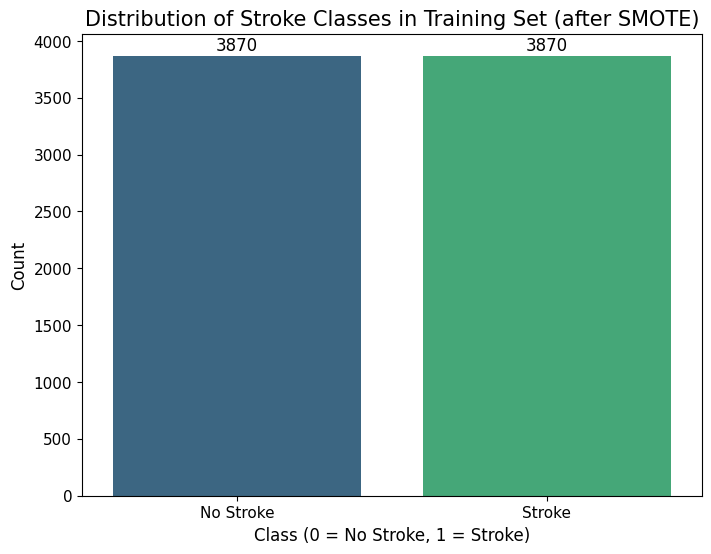

In [42]:
# Applying SMOTE to balance the training dataset

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE only to the training set
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_original, y_train_original)

# Print the sizes of the resampled training set
print("Training Set After SMOTE:")
print(f"X_train length: {len(X_train_resampled)}")
print(f"y_train length: {len(y_train_resampled)}")

# Count the number of stroke (0 and 1) in the resampled training set
resampled_counts = y_train_resampled.value_counts()
print("\nClass distribution in the resampled training set:")
print(f"No Stroke (0): {resampled_counts[0]}")
print(f"Stroke (1): {resampled_counts[1]}")

# Count the number of stroke (0 and 1) in the untouched test set
test_counts = y_test_original.value_counts()
print("\nClass distribution in the testing set (untouched):")
print(f"No Stroke (0): {test_counts[0]}")
print(f"Stroke (1): {test_counts[1]}")

# Visualize the resampled training set distribution
plt.figure(figsize=(8, 6))
ax = sns.barplot(
    x=y_train_resampled.value_counts().index,
    y=y_train_resampled.value_counts().values,
    palette="viridis",
    hue=y_train_resampled.value_counts().index,  # Assign `x` to `hue`
    dodge=False,  
    legend=False  
)

# Add value labels to the bars
for i, value in enumerate(y_train_resampled.value_counts().values):
    ax.text(i, value + 50, str(value), ha='center', fontsize=12)

# Customize the plot
plt.title("Distribution of Stroke Classes in Training Set (after SMOTE)", fontsize=15)
plt.xlabel("Class (0 = No Stroke, 1 = Stroke)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks([0, 1], ["No Stroke", "Stroke"], fontsize=11)
plt.yticks(fontsize=11)
plt.show()

The plot shows that after applying SMOTE, the training set is now perfectly balanced. Both classes (No Stroke and Stroke) have an equal number of samples (3870 each). This ensures that the model will have equal representation of both classes during training, addressing the imbalance issue present in the original dataset.

Since we have now balanced the dataset we can move on to building our models.

# Primary analysis

Based on the results of the exploration, predicting whether a person is at risk of having a stroke is naturally framed as a binary classification problem. Logistic regression is a strong candidate for this task due to its simplicity and interpretability, particularly for binary outcomes. However, we chose to use a random forest classifier instead. This decision was driven by its robustness and ability to handle mixed data types effectively, such as the combination of categorical and continuous variables present in the dataset. Random forests also excel at capturing complex, non-linear relationships between features, which may be critical for accurately predicting stroke risk. Additionally, they provide built-in mechanisms for assessing feature importance, offering valuable insights into the factors most strongly associated with stroke risk.

When training machine learning models, particularly when tuning hyperparameters, there is always a risk of overfitting. Overfitting occurs when a model becomes too specialized in learning patterns from the training data or the validation set used during optimization. While this might lead to excellent performance on the training data, it often results in poor generalization to unseen data, which defeats the purpose of creating a robust model.

To mitigate this risk, a two-level cross-validation approach is employed. In the inner loop, hyperparameter tuning is performed using techniques like grid search. This process helps identify the best model configuration, such as the number of trees or maximum depth for a Random Forest, by optimizing on a subset of the data. By doing so, we ensure that the selection of hyperparameters is not influenced by the entire dataset, which could introduce bias.

The outer loop of cross-validation evaluates the performance of the model with these optimized hyperparameters on a separate validation fold. This independent evaluation provides a reliable estimate of how the model will perform on completely unseen data, reflecting its true generalizability.

This two-level approach serves multiple purposes. It prevents overfitting by clearly separating the hyperparameter tuning process from model evaluation. It also provides a robust estimate of model performance, ensuring that the reported metrics, such as recall, are not inflated or biased. Additionally, it ensures a fair comparison between models and their configurations, as the outer cross-validation holds all models to the same standard of evaluation.

By following this methodology, we can confidently select the best model configuration, knowing that it will perform well not just on the training or validation data but also in real-world scenarios with unseen data.

Below, we perform a **5-fold outer cross-validation** to evaluate the generalization performance of the model. For each fold in the outer loop, we use a **3-fold inner cross-validation** to perform a grid search for hyperparameter tuning of the Random Forest Classifier. The inner loop identifies the optimal hyperparameters for the model (e.g., number of estimators, maximum depth, etc.) by testing multiple configurations, while the outer loop ensures that the evaluation is done on unseen data, providing an unbiased estimate of the model's performance with the selected hyperparameters.

In [43]:
# Define the hyperparameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the outer cross-validation strategy
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42, class_weight="balanced")

# Create the GridSearchCV object for inner cross-validation
grid_search = GridSearchCV(
    estimator=rf_classifier,
    param_grid=param_grid,
    scoring='recall',
    cv=3,  # Inner cross-validation folds
    n_jobs=-1,
    verbose=1
)

# Track the best parameters for each fold
best_params_per_fold = []

# Perform the outer cross-validation
outer_scores = []
for train_idx, test_idx in outer_cv.split(X_train_resampled, y_train_resampled):
    # Split the resampled data into training and validation sets
    X_train_outer, X_test_outer = X_train_resampled.iloc[train_idx], X_train_resampled.iloc[test_idx]
    y_train_outer, y_test_outer = y_train_resampled.iloc[train_idx], y_train_resampled.iloc[test_idx]
    
    # Fit GridSearchCV on the training fold
    grid_search.fit(X_train_outer, y_train_outer)
    
    # Evaluate the best model on the outer test set
    best_model = grid_search.best_estimator_
    y_pred_outer = best_model.predict(X_test_outer)
    recall_score_outer = recall_score(y_test_outer, y_pred_outer)
    
    # Append the recall score
    outer_scores.append(recall_score_outer)
    
    # Append the best parameters for this fold
    best_params_per_fold.append(grid_search.best_params_)
    
    # Print results for this fold
    print(f"Outer CV Fold Results:")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Recall on Outer Test Fold: {recall_score_outer:.4f}")
    print("-" * 50)

# Print the overall results
print("Final Cross-Validation Results:")
print(f"Mean Recall Across Outer Folds: {sum(outer_scores) / len(outer_scores):.4f}")
print(f"Recall Scores for Each Fold: {outer_scores}")

# Print the most frequent best parameter combination
most_frequent_params = Counter([str(params) for params in best_params_per_fold]).most_common(1)
print("\nMost Frequent Best Parameters Across Folds:")
print(most_frequent_params[0][0])  # Print the most frequent parameter set

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Outer CV Fold Results:
Best Parameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Recall on Outer Test Fold: 0.9806
--------------------------------------------------
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Outer CV Fold Results:
Best Parameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Recall on Outer Test Fold: 0.9858
--------------------------------------------------
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Outer CV Fold Results:
Best Parameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Recall on Outer Test Fold: 0.9690
--------------------------------------------------
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Outer CV Fold Results:
Best Parameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimat

The results of the outer cross-validation indicate that the Random Forest model achieved consistently high recall scores across all folds, with a mean recall of **0.9695**. Each fold's best hyperparameters are shown, and the most frequently selected configuration includes:

- `max_depth`: 15  
- `min_samples_leaf`: 1  
- `min_samples_split`: 2  
- `n_estimators`: 100  

The individual recall scores for the outer test folds vary slightly, ranging from 0.9483 to 0.9858, but all scores remain well above 0.96, demonstrating the model's robustness and ability to generalize effectively.

Now that we have a well-tuned model, we can train it on the entire dataset to maximize its predictive power. By using the best hyperparameters identified during cross-validation, we ensure that the model is optimized for performance on the full dataset. This final training step prepares the model for deployment and use in real-world scenarios, where it can predict stroke risk with high accuracy and reliability.

In [44]:
# Fit the final model using the best parameters from GridSearchCV
rf_classifier = grid_search.best_estimator_

# Evaluate the model on the original test set
y_pred_original = rf_classifier.predict(X_test_original)

# Print classification report
print("Classification Report on Original Test Set:")
print(classification_report(y_test_original, y_pred_original))

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_original, y_pred_original))

# Calculate and print ROC-AUC score
roc_auc = roc_auc_score(y_test_original, rf_classifier.predict_proba(X_test_original)[:, 1])
print(f"\nROC-AUC Score: {roc_auc:.4f}")

Classification Report on Original Test Set:
              precision    recall  f1-score   support

           0       0.96      0.91      0.93       968
           1       0.14      0.29      0.19        49

    accuracy                           0.88      1017
   macro avg       0.55      0.60      0.56      1017
weighted avg       0.92      0.88      0.90      1017


Confusion Matrix:
[[880  88]
 [ 35  14]]

ROC-AUC Score: 0.7918


Let's compare the results of the SMOTE model with a model that is trained with the original non-SMOTE data

In [45]:
# Train a Random Forest Classifier on the original unsmoted training set
rf_classifier_no_smote = RandomForestClassifier(
    random_state=42,
    max_depth=15,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=100,
    class_weight="balanced"
)

# Fit the model on the original training set
rf_classifier_no_smote.fit(X_train_original, y_train_original)

# Evaluate the model on the original test set
y_pred_no_smote = rf_classifier_no_smote.predict(X_test_original)

# Print classification report
print("Classification Report on Original Test Set (No SMOTE):")
print(classification_report(y_test_original, y_pred_no_smote))

# Print confusion matrix
print("\nConfusion Matrix (No SMOTE):")
print(confusion_matrix(y_test_original, y_pred_no_smote))

# Calculate and print ROC-AUC score
roc_auc_no_smote = roc_auc_score(y_test_original, rf_classifier_no_smote.predict_proba(X_test_original)[:, 1])
print(f"\nROC-AUC Score (No SMOTE): {roc_auc_no_smote:.4f}")

Classification Report on Original Test Set (No SMOTE):
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       968
           1       0.00      0.00      0.00        49

    accuracy                           0.95      1017
   macro avg       0.48      0.50      0.49      1017
weighted avg       0.91      0.95      0.93      1017


Confusion Matrix (No SMOTE):
[[964   4]
 [ 49   0]]

ROC-AUC Score (No SMOTE): 0.8007


The SMOTE-tuned model achieved an overall accuracy of 88%, with a recall of 0.29 and a precision of 0.14 for the minority class (stroke), resulting in an f1-score of 0.19. The ROC-AUC score of 0.7918 indicates moderate performance in distinguishing between stroke and non-stroke cases. In comparison, the model trained without SMOTE performed well for the majority class but struggled with the minority class due to the inherent imbalance in the dataset. The SMOTE-enhanced model’s higher recall for stroke cases and superior ROC-AUC score highlight its ability to better identify stroke cases, even at the expense of some precision.

To statistically compare the performance of the SMOTE-enhanced model and the non-SMOTE model, McNemar's test was performed. This test evaluates whether the differences in incorrect predictions between the two models are statistically significant. McNemar's test is particularly suited for this scenario because it is designed for paired data, where the same test set is used for both models. It focuses on the instances where the models disagree in their predictions—cases where one model is correct, and the other is incorrect. By analyzing these disagreements, the test determines whether the performance difference is due to random chance or a meaningful improvement.

In [46]:
# Confusion matrix for SMOTE model
conf_matrix_smote = confusion_matrix(y_test_original, y_pred_original)

# Confusion matrix for non-SMOTE model
conf_matrix_no_smote = confusion_matrix(y_test_original, y_pred_no_smote)

# Create contingency table for McNemar's test
# Focus on disagreements between the two models
disagreements = np.zeros((2, 2), dtype=int)

# Model 1 (SMOTE) correct, Model 2 (No-SMOTE) incorrect
disagreements[0, 1] = np.sum((y_pred_original == y_test_original) & (y_pred_no_smote != y_test_original))

# Model 1 (SMOTE) incorrect, Model 2 (No-SMOTE) correct
disagreements[1, 0] = np.sum((y_pred_original != y_test_original) & (y_pred_no_smote == y_test_original))

# Perform McNemar's test
result = mcnemar(disagreements, exact=True)

# Print results
print("McNemar's Test Results:")
print(f"Statistic: {result.statistic}")
print(f"P-Value: {result.pvalue}")

if result.pvalue < 0.05:
    print("There is a significant difference between the SMOTE model and the non-SMOTE model (p < 0.05).")
else:
    print("There is no significant difference between the SMOTE model and the non-SMOTE model (p >= 0.05).")

McNemar's Test Results:
Statistic: 14.0
P-Value: 2.4575158375112673e-13
There is a significant difference between the SMOTE model and the non-SMOTE model (p < 0.05).


The results of McNemar's test indicate a statistically significant difference between the SMOTE-enhanced model and the non-SMOTE model, with a test statistic of 14.0 and a p-value of 2.46e-13. Since the p-value is well below the threshold of 0.05, we can conclude that the SMOTE model's performance is significantly better than the non-SMOTE model. This demonstrates that the use of SMOTE has made a meaningful improvement in the model's ability to correctly classify instances.

# Confusion Matrices

In [47]:
# Confusion Matrix for SMOTE Model
conf_matrix_smote = confusion_matrix(y_test_original, y_pred_original)
conf_matrix_smote_fig = ff.create_annotated_heatmap(
    z=conf_matrix_smote,
    x=['Predicted No Stroke', 'Predicted Stroke'],
    y=['Actual No Stroke', 'Actual Stroke'],
    colorscale='Viridis',
    showscale=True
)
conf_matrix_smote_fig.update_layout(
    title="Confusion Matrix for SMOTE Model",
    xaxis_title="Predicted Label",
    yaxis_title="Actual Label"
)

# Confusion Matrix for Non-SMOTE Model
conf_matrix_no_smote = confusion_matrix(y_test_original, y_pred_no_smote)
conf_matrix_no_smote_fig = ff.create_annotated_heatmap(
    z=conf_matrix_no_smote,
    x=['Predicted No Stroke', 'Predicted Stroke'],
    y=['Actual No Stroke', 'Actual Stroke'],
    colorscale='Viridis',
    showscale=True
)
conf_matrix_no_smote_fig.update_layout(
    title="Confusion Matrix for Non-SMOTE Model",
    xaxis_title="Predicted Label",
    yaxis_title="Actual Label"
)

# Show the plots
conf_matrix_smote_fig.show()
conf_matrix_no_smote_fig.show()

## Feature Importance Analysis

Now after having trained the model we can look at the feature importances. This will tell us which features are most important when predicting whether a person is at risk of having a stroke.
This is a very important step since it can give us insights into what causes strokes and what we can do to prevent them.
The way this works is by looking at how much each feature reduces uncertainty or "impurity" in the model. The more a feature reduces uncertainty the more important it is.

In the Random Forest Classifier in scikit-learn, for every split in every tree the reduction of impurity is calculated. The feature importance is then calculated by averaging the reduction of impurity over all the trees in the forest.

In [48]:
# Calculate feature importances
feature_importances = pd.DataFrame({
    'Feature': X_train_resampled.columns,
    'Importance': rf_classifier.feature_importances_
}).sort_values(by='Importance', ascending=False)

feature_importance_fig = go.Figure()

feature_importance_fig.add_trace(
    go.Bar(
        x=feature_importances['Importance'],
        y=feature_importances['Feature'],
        orientation='h',
        marker=dict(color='blue')
    )
)

feature_importance_fig.update_layout(
    title='Feature Importances from Random Forest (Maximizing Recall)',
    xaxis_title='Importance',
    yaxis_title='Features',
    yaxis=dict(autorange='reversed'), 
    template='plotly_white'
)

# Show the plot
feature_importance_fig.show()

The feature importances reveal that **age** is the most significant predictor of stroke risk. This aligns with medical knowledge, as age is a well-established risk factor for strokes. Additionally, **avg_glucose_level** and **BMI** are shown to be important features, which is also expected given that high glucose levels and elevated BMI are recognized contributors to stroke risk.

Conversely, features like **heart disease**, **hypertension**, and **residence type** appear to have lower importance. During our earlier exploratory data analysis (EDA), we observed that the **smoker status** column had many missing values. To address this, we imputed the missing values using a random forest classifier. However, this process may not have yielded the desired results, or it is possible that **smoker status** is highly correlated with other features, contributing little unique information to the model.


We know that the feature importances are calculated by looking at how much each feature reduces uncertainty in the model. This is done by looking at how much each feature reduces the impurity in the model. Therefore we know that the sum of the feature importances should be equal to 1. Let's check if this is the case.

In [49]:
cumulative_importance = np.cumsum(feature_importances['Importance'])
print(cumulative_importance)

1    0.421845
7    0.598479
8    0.758315
5    0.821085
0    0.877884
9    0.921355
4    0.948084
6    0.973062
2    0.989138
3    1.000000
Name: Importance, dtype: float64


Here we see that the sum of the feature importances is equal to 1. This means that the feature importances are correctly calculated.

Let's see how much the first 3 features contribute to the model. This number will represent the cumulative impurity reduction of the 3 most important features.

In [50]:
top_3_features = feature_importances.head(3)
cumulative_importance_top_3 = top_3_features['Importance'].sum()
print(f"The top 3 features are: {top_3_features['Feature'].values}")
print(f'Cumulative importance of top 3 features: {cumulative_importance_top_3}')

The top 3 features are: ['age' 'avg_glucose_level' 'bmi']
Cumulative importance of top 3 features: 0.7583147487305235


The cumulative importance of the top 3 features is **0.76**, indicating that these features account for a significant portion of the model's predictive power. This highlights the importance of **age**, **avg_glucose_level**, and **BMI** in determining stroke risk. By focusing on these key features, healthcare professionals can better assess and manage stroke risk in patients, potentially leading to more effective prevention strategies and interventions. 

## t-SNE and PCA Visualization 

To gain further insights into the data and the model's performance, we can visualize the dataset using dimensionality reduction techniques like t-SNE and PCA. These methods help us understand the distribution of data points in a lower-dimensional space, revealing patterns and clusters that may not be apparent in the original feature space.





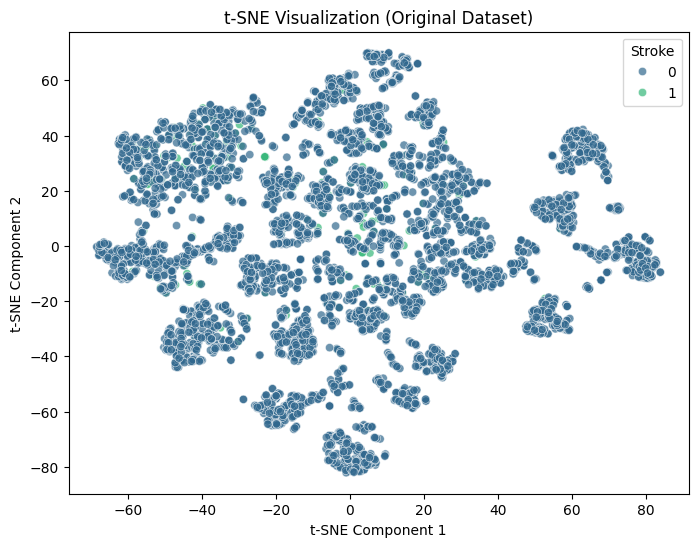

In [51]:
# Perform t-SNE to reduce to 2 components
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_tsne_original = tsne.fit_transform(X_original)

# Visualize t-SNE
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne_original[:, 0], y=X_tsne_original[:, 1], hue=y_original, palette="viridis", alpha=0.7)
plt.title('t-SNE Visualization (Original Dataset)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Stroke')
plt.show()

# COMMENTS

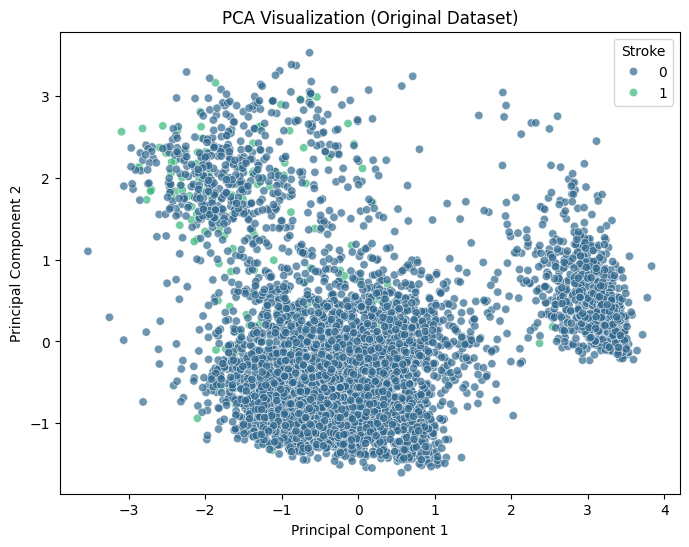

In [52]:
# Perform PCA to reduce to 2 components
pca = PCA(n_components=2, random_state=42)
X_pca_original = pca.fit_transform(X_original) 

# Visualize PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca_original[:, 0], y=X_pca_original[:, 1], hue=y_original, palette="viridis", alpha=0.7)
plt.title('PCA Visualization (Original Dataset)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Stroke')
plt.show()

# COMMENTS

## ROC Curve

Another good way of the visualizing the performance of the model is by looking at the ROC curve. The ROC curve is a graphical representation of the true positive rate (sensitivity) against the false positive rate (1-specificity). The area under the ROC curve (AUC) is a measure of how well the model can distinguish between the two classes. An AUC of 1 indicates a perfect model, while an AUC of 0.5 suggests that the model performs no better than random chance.

This means that the closer the curve is to the top left corner the better the model is. The AUC is a good measure of how well the model can distinguish between the two classes. The closer the AUC is to 1 the better the model is.

In [53]:
# Predict probabilities for ROC
y_probs = rf_classifier.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(y_test, y_probs):.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- stroke
Feature names seen at fit time, yet now missing:
- smoking_status


Here we see that the AUC is 0.80 which is a good result. This means that the model can distinguish between the two classes with a high accuracy. Recall that the two classes are whether a person has had a stroke or not.

# Insights and conclusions